In [1]:
from transformers import (
    AutoModelForSequenceClassification, 
    AutoTokenizer, 
    AutoConfig,
    Trainer, 
    TrainingArguments, 
    EarlyStoppingCallback,
    DataCollatorWithPadding,
    set_seed
)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from tokenizers import AddedToken
from datasets import Dataset
import matplotlib.pyplot as plt
import transformers
import seaborn as sns
import pandas as pd
import matplotlib
import numpy as np
import warnings
import random
import shutil
import torch
import wandb
import os

transformers.logging.set_verbosity_error()
warnings.filterwarnings('ignore')
os.environ['WANDB_SILENT'] = 'true'
matplotlib.style.use('ggplot')

2024-05-01 12:41:12.211437: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 12:41:12.211591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 12:41:12.341582: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
SEED = 27

DEBERTA_V3_XSMALL   = 'microsoft/deberta-v3-xsmall'  # 22M
DEBERTA_V3_SMALL    = 'microsoft/deberta-v3-small'   # 44M
DEBERTA_V3_BASE     = 'microsoft/deberta-v3-base'    # 86M
DEBERTA_V3_LARGE    = 'microsoft/deberta-v3-large'   # 304M

MODEL_NAME = DEBERTA_V3_XSMALL
MAX_TOKEN_LENGTH = 1024
LEARNING_RATE = 1e-5
MAX_EPOCHS = 50
TRAIN_BATCH_SIZE = 4
EVAL_BATCH_SIZE= 8
EVAL_STEPS = 100
N_FOLDS = 10

In [3]:
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
set_seed(SEED)

In [4]:
use_wandb = True

CHECKPOINT_BASE_NAME = f'{MODEL_NAME.split("/")[1]}-{MAX_TOKEN_LENGTH}-{TRAIN_BATCH_SIZE}-{LEARNING_RATE}'
if use_wandb:
    from kaggle_secrets import UserSecretsClient
    wandb_api_key = UserSecretsClient().get_secret('WANDB_API_KEY')
    os.environ['WANDB_PROJECT'] = 'automated-essay-scoring'
    os.environ['WANDB_API_KEY'] = wandb_api_key
    logger_config = {'report_to': 'wandb', 'run_name': CHECKPOINT_BASE_NAME}
else:
    logger_config = {'report_to': 'none'}

# Loading Data and Taking a Quick Look at the Text Lengths

In [5]:
dataset = pd.read_csv('/kaggle/input/learning-agency-lab-automated-essay-scoring-2/train.csv')

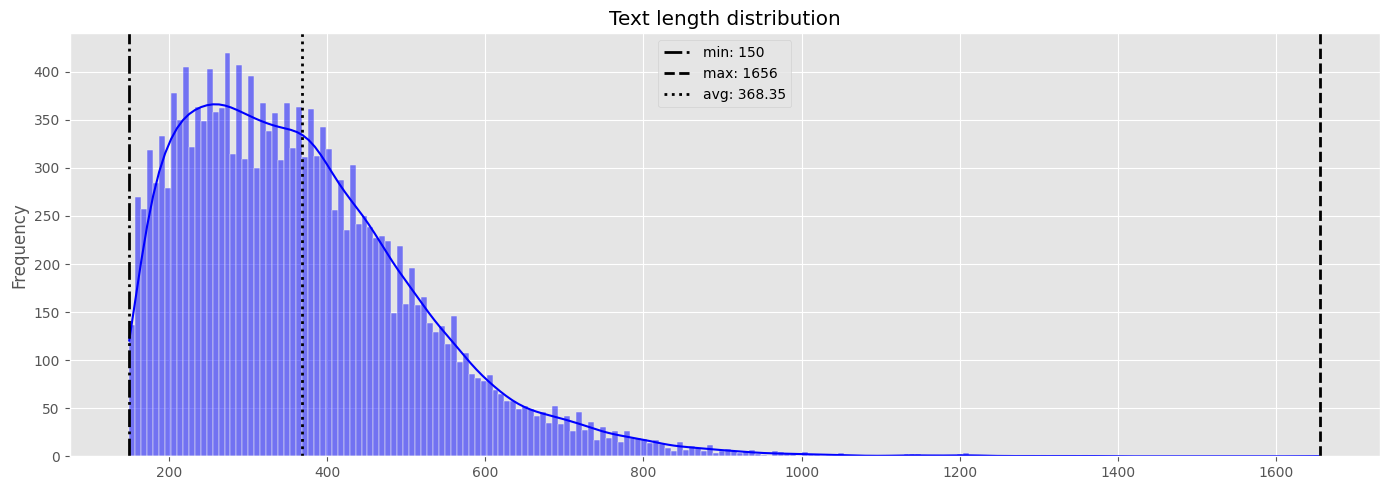

In [6]:
dataset['length'] = dataset['full_text'].apply(lambda x: len(x.split()))

train_avg_length = dataset.length.mean()
train_max_length = dataset.length.max()
train_min_length = dataset.length.min()

plt.figure(figsize=(14, 5))
sns.histplot(dataset.length.values, kde=True, color='blue', bins=200)
plt.axvline(train_min_length, color='black', linestyle='dashdot', linewidth=2, label=f'min: {train_min_length}')
plt.axvline(train_max_length, color='black', linestyle='dashed', linewidth=2, label=f'max: {train_max_length}')
plt.axvline(train_avg_length, color='black', linestyle='dotted', linewidth=2, label=f'avg: {train_avg_length:.2f}')
plt.title('Text length distribution')
plt.ylabel('Frequency')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

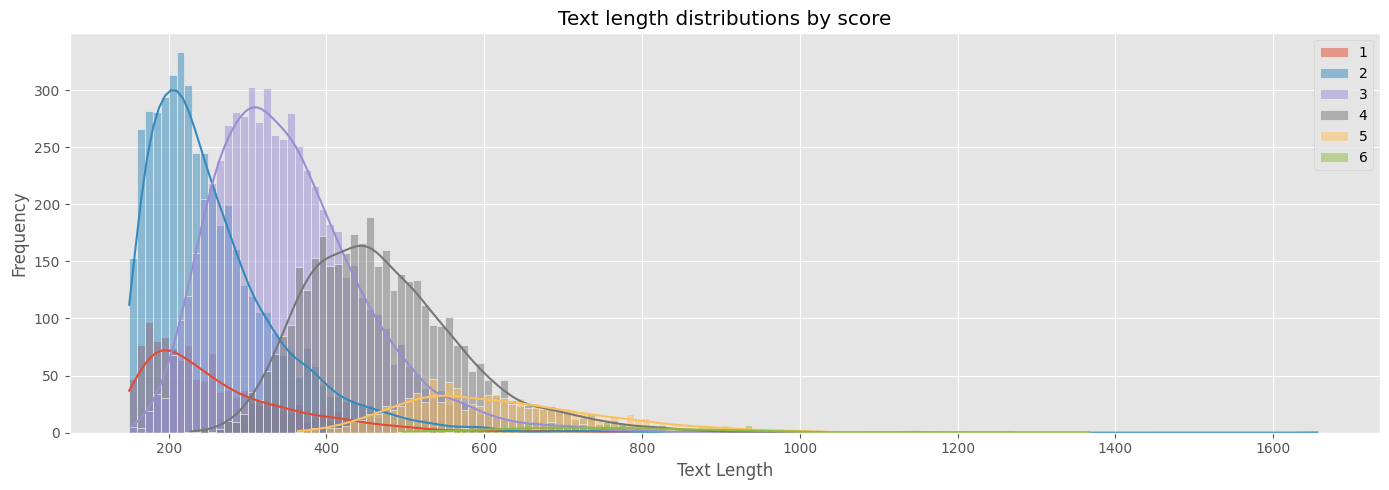

In [7]:
bin_width = 10
bins = range(
    dataset.length.min(),
    dataset.length.max() + bin_width, 
    bin_width
)

plt.figure(figsize=(14, 5))
for label, df in dataset.groupby('score'):
    sns.histplot(df.length.values, kde=True, bins=bins, label=label, alpha=0.5)
plt.title('Text length distributions by score')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Defining Tokenizer, Training Arguments, and Metrics

In [8]:
dataset['label'] = dataset['score'].apply(lambda x: x - 1)
dataset['label'] = dataset['label'].astype('float32') 

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
for i, (_, val_index) in enumerate(skf.split(dataset, dataset['label'])):
    dataset.loc[val_index, 'fold'] = i

In [9]:
class Tokenizer:
    def __init__(self, train_df, val_df, model_name=MODEL_NAME, max_length=MAX_TOKEN_LENGTH):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.add_tokens([AddedToken('\n', normalized=False)])
        self.tokenizer.add_tokens([AddedToken(' ' * 2, normalized=False)])
        
        self.train_df = train_df
        self.val_df = val_df
        self.max_token_length = max_length

    def tokenizer_fn(self, sample):
        return self.tokenizer(
            sample['full_text'],
            truncation=True,
            max_length=self.max_token_length
        )

    def tokenize(self):
        train_ds = Dataset.from_pandas(self.train_df)
        valid_ds = Dataset.from_pandas(self.val_df)

        tokenized_train = train_ds.map(self.tokenizer_fn, batched=True).remove_columns(['length', 'essay_id', 'full_text', 'score','__index_level_0__'])
        tokenized_valid = valid_ds.map(self.tokenizer_fn, batched=True).remove_columns(['length', 'essay_id', 'full_text', 'score','__index_level_0__'])

        return tokenized_train, tokenized_valid, self.tokenizer

In [10]:
def compute_metrics(preds):
    predictions, labels = preds
    score = cohen_kappa_score(
        y1=labels,
        y2=predictions.clip(0, 5).round(0),
        weights='quadratic'
    )
    return {'qwk': score}

In [11]:
training_args = TrainingArguments(
    num_train_epochs=MAX_EPOCHS,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=EVAL_BATCH_SIZE,
    gradient_accumulation_steps=4,
    learning_rate=LEARNING_RATE,
    lr_scheduler_type='linear',
    output_dir=f'/kaggle/working/{CHECKPOINT_BASE_NAME}', 
    do_eval=True,
    evaluation_strategy='steps',
    save_strategy='steps',
    eval_steps=EVAL_STEPS,
    save_steps=EVAL_STEPS,
    logging_steps=EVAL_STEPS,
    load_best_model_at_end=True,
    save_total_limit=1,
    seed=SEED,
    data_seed=SEED,
    fp16=True,
    metric_for_best_model='qwk',
    greater_is_better=True,
    disable_tqdm=False,
    **logger_config
)

# Training

In [12]:
histories = {}
oof_preds = []

for fold_idx, fold in enumerate(range(len(dataset['fold'].unique()))):
    print("Started training fold ", fold_idx + 1)
    train_df = dataset[dataset['fold'] != fold]
    val_df = dataset[dataset['fold'] == fold]

    tokenized_train, tokenized_val, tokenizer = Tokenizer(train_df, val_df).tokenize()
    
    config = AutoConfig.from_pretrained(MODEL_NAME)
    config.attention_probs_dropout_prob = 0.0 
    config.hidden_dropout_prob = 0.0 
    config.num_labels = 1 

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)
    model.resize_token_embeddings(len(tokenizer))
    
    checkpoint_name = f'{CHECKPOINT_BASE_NAME}-fold{fold_idx}'
    training_args.output_dir = f'/kaggle/working/{checkpoint_name}'
    if use_wandb:
        training_args.run_name = checkpoint_name

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
    )
    
    trainer.train()
    trainer.evaluate()
    
    if use_wandb:
        wandb.finish()
    
    histories[fold_idx] = trainer.state.log_history
    
    # For computing the overall score
    targets = val_df['score'].values
    predictions = trainer.predict(tokenized_val).predictions
    val_df['prediction'] = predictions
    oof_preds.append(val_df)

Started training fold  1


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Map:   0%|          | 0/15576 [00:00<?, ? examples/s]

Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/241M [00:00<?, ?B/s]

Step,Training Loss,Validation Loss,Qwk
100,2.095300,0.620347,0.430033
200,0.472000,0.473053,0.684065
300,0.432500,0.457919,0.682468
400,0.406600,0.389894,0.728848
500,0.406800,0.469051,0.659989
600,0.360700,0.425129,0.725156
700,0.366000,0.397006,0.762709
800,0.338000,0.366738,0.761926
900,0.348300,0.367018,0.772545
1000,0.350200,0.362589,0.738401


Started training fold  2


Map:   0%|          | 0/15576 [00:00<?, ? examples/s]

Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Qwk
100,1.999400,0.623166,0.504128
200,0.474000,0.427353,0.711959
300,0.423500,0.427079,0.693875
400,0.408200,0.392326,0.717911
500,0.376900,0.372964,0.764316
600,0.391300,0.363411,0.761484
700,0.361600,0.350304,0.778835
800,0.344600,0.372283,0.778950
900,0.361900,0.544154,0.704635
1000,0.340300,0.337623,0.774873


Started training fold  3


Map:   0%|          | 0/15576 [00:00<?, ? examples/s]

Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Qwk
100,2.205100,0.661160,0.345069
200,0.521600,0.479594,0.680131
300,0.438800,0.397693,0.721005
400,0.418300,0.377665,0.732233
500,0.390600,0.391361,0.735049
600,0.394700,0.344076,0.772564
700,0.370000,0.337760,0.767732
800,0.365600,0.356060,0.748090
900,0.309500,0.321650,0.790389
1000,0.343500,0.322467,0.787317


Started training fold  4


Map:   0%|          | 0/15576 [00:00<?, ? examples/s]

Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Qwk
100,2.126000,0.557797,0.509612
200,0.525000,0.462918,0.674302
300,0.411100,0.456958,0.670145
400,0.381600,0.420848,0.702392
500,0.430800,0.468089,0.683927
600,0.374000,0.367556,0.756939
700,0.366300,0.357694,0.778882
800,0.380800,0.370694,0.743294
900,0.340800,0.325086,0.787014
1000,0.355200,0.357895,0.736326


Started training fold  5


Map:   0%|          | 0/15576 [00:00<?, ? examples/s]

Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Qwk
100,1.943600,0.563970,0.633536
200,0.484000,0.402782,0.722856
300,0.408100,0.393298,0.716306
400,0.400900,0.385827,0.764187
500,0.362300,0.383583,0.770186
600,0.360300,0.375976,0.728556
700,0.367900,0.351553,0.765102
800,0.359800,0.338381,0.761282
900,0.372200,0.367698,0.730867
1000,0.361200,0.329783,0.773336


Started training fold  6


Map:   0%|          | 0/15576 [00:00<?, ? examples/s]

Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Qwk
100,2.278400,0.604997,0.443728
200,0.529000,0.437368,0.706747
300,0.467300,0.391944,0.712891
400,0.421000,0.397716,0.719889
500,0.373400,0.371895,0.754075
600,0.334600,0.357665,0.765910
700,0.373300,0.356988,0.756799
800,0.356800,0.346225,0.789043
900,0.368400,0.351494,0.754774
1000,0.335900,0.327598,0.785936


Started training fold  7


Map:   0%|          | 0/15576 [00:00<?, ? examples/s]

Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Qwk
100,2.198900,0.649165,0.395054
200,0.558600,0.455644,0.697390
300,0.426400,0.422991,0.710448
400,0.384100,0.385267,0.727807
500,0.385600,0.387716,0.760663
600,0.375200,0.369807,0.749185
700,0.437600,0.392292,0.744456
800,0.352800,0.367101,0.766058
900,0.355600,0.349872,0.792184
1000,0.353100,0.478962,0.682032


Started training fold  8


Map:   0%|          | 0/15577 [00:00<?, ? examples/s]

Map:   0%|          | 0/1730 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Qwk
100,2.487300,0.525260,0.690974
200,0.484200,0.403732,0.700626
300,0.419000,0.494904,0.689590
400,0.457000,0.340925,0.767547
500,0.443300,0.349055,0.747741
600,0.396200,0.325276,0.788271
700,0.375800,0.346991,0.752286
800,0.338100,0.310779,0.798696
900,0.357900,0.303644,0.806016
1000,0.345700,0.312223,0.803793


Started training fold  9


Map:   0%|          | 0/15577 [00:00<?, ? examples/s]

Map:   0%|          | 0/1730 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Qwk
100,2.219000,0.590296,0.370621
200,0.507800,0.446678,0.692614
300,0.429500,0.393746,0.721986
400,0.400900,0.373408,0.712498
500,0.402600,0.359734,0.742182
600,0.368100,0.364085,0.768184
700,0.393200,0.339654,0.786169
800,0.362000,0.352443,0.781694
900,0.321400,0.323196,0.807132
1000,0.319900,0.314188,0.782635


Started training fold  10


Map:   0%|          | 0/15577 [00:00<?, ? examples/s]

Map:   0%|          | 0/1730 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Qwk
100,2.007200,0.548334,0.668138
200,0.546900,0.436285,0.689818
300,0.423200,0.446864,0.694489
400,0.417900,0.399005,0.757954
500,0.386600,0.365334,0.748079
600,0.391500,0.360958,0.762880
700,0.334300,0.392169,0.704372
800,0.346400,0.341911,0.764535
900,0.332800,0.345851,0.771608
1000,0.353700,0.331795,0.775519


# Results

In [13]:
oof_preds = pd.concat(oof_preds)
oof_preds.to_csv('oof_preds.csv', index=False)
oof_preds.head()

,essay_id,full_text,score,length,label,fold,prediction
2,001ab80,People always wish they had the same technolog...,4,550,3.0,0.0,3.705078
6,0033037,The posibilty of a face reconizing computer wo...,2,179,1.0,0.0,1.178711
12,005a72e,I agree that driverless cars are a developing ...,4,612,3.0,0.0,3.427734
71,0163804,Cars have been a necessity to us for as long a...,4,503,3.0,0.0,3.134766
72,01665d5,I think that the new facial action coding syst...,3,305,2.0,0.0,1.897461


In [14]:
score = cohen_kappa_score(oof_preds.score.values, oof_preds.prediction.values.clip(1,6).round(0), weights='quadratic')
print(f"Score: {score}")

Score: 0.5585038002245899


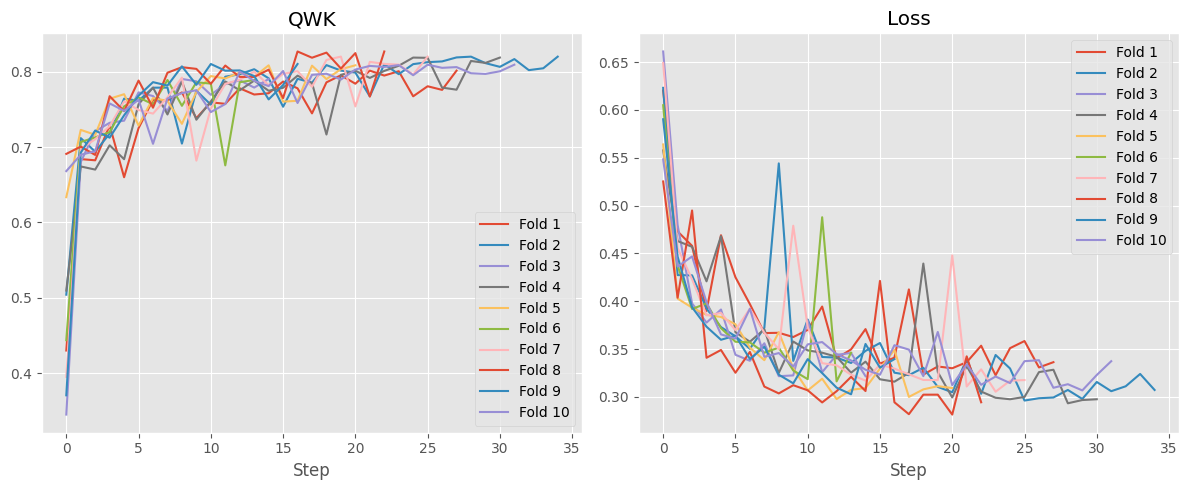

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for fold, history in histories.items():
    history_df = pd.DataFrame(history).dropna(subset=['eval_loss']).set_index('step')
    metrics = {
        'QWK': history_df['eval_qwk'].values,
        'Loss': history_df['eval_loss'].values
    }
    for i, metric in enumerate(['QWK', 'Loss']):
        ax[i].plot(metrics[metric], label=f'Fold {fold+1}')
        ax[i].set_title(metric)
        ax[i].set_xlabel('Step')
        ax[i].legend()

plt.tight_layout()
plt.show() 

In [16]:
shutil.rmtree("wandb", ignore_errors=True)

# Credits
This work is based on the following notebooks:
- https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800?scriptVersionId=174239814
- https://www.kaggle.com/code/idv2005/deberta-baseline-train
- https://www.kaggle.com/code/idv2005/deberta-baseline-inference
- https://www.kaggle.com/code/hashidoyuto/deberta-baseline-aes2-0-train
- https://www.kaggle.com/code/hashidoyuto/deberta-5fold-infer-aes2-0?scriptVersionId=173129662

And the following discussion posts:
- https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/discussion/498571
- https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/discussion/497832